# **CIFAR-100 Image Classification**

In [50]:
import tarfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import tensorflow as tf
import tensorflow.keras as keras
%matplotlib inline
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import Sequence, to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.transform import resize
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import seaborn as sns
import cv2
import albumentations as albu

## **Dowload Dataset**

In [2]:
from torchvision.datasets.utils import download_url

# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar100.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
  
data_dir = './data/cifar100'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

  0%|          | 0/169168619 [00:00<?, ?it/s]

['test', 'train']
['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']


In [46]:
import glob2

train_dir = 'data\\cifar100\\train\\*\\*\\*'
test_dir = 'data\\cifar100\\test\\*\\*\\*'
train_fns = glob2.glob(train_dir)
test_fns = glob2.glob(test_dir)
print('train all filenames size: ',len(train_fns))
print('test all filenames size', len(test_fns))

train all filenames size:  50000
test all filenames size 10000


In [47]:
labels = ['']*len(train_fns)
for i,fn in enumerate(train_fns):
    labels[i] = (fn.split('\\')[4])

### **Data visualization**

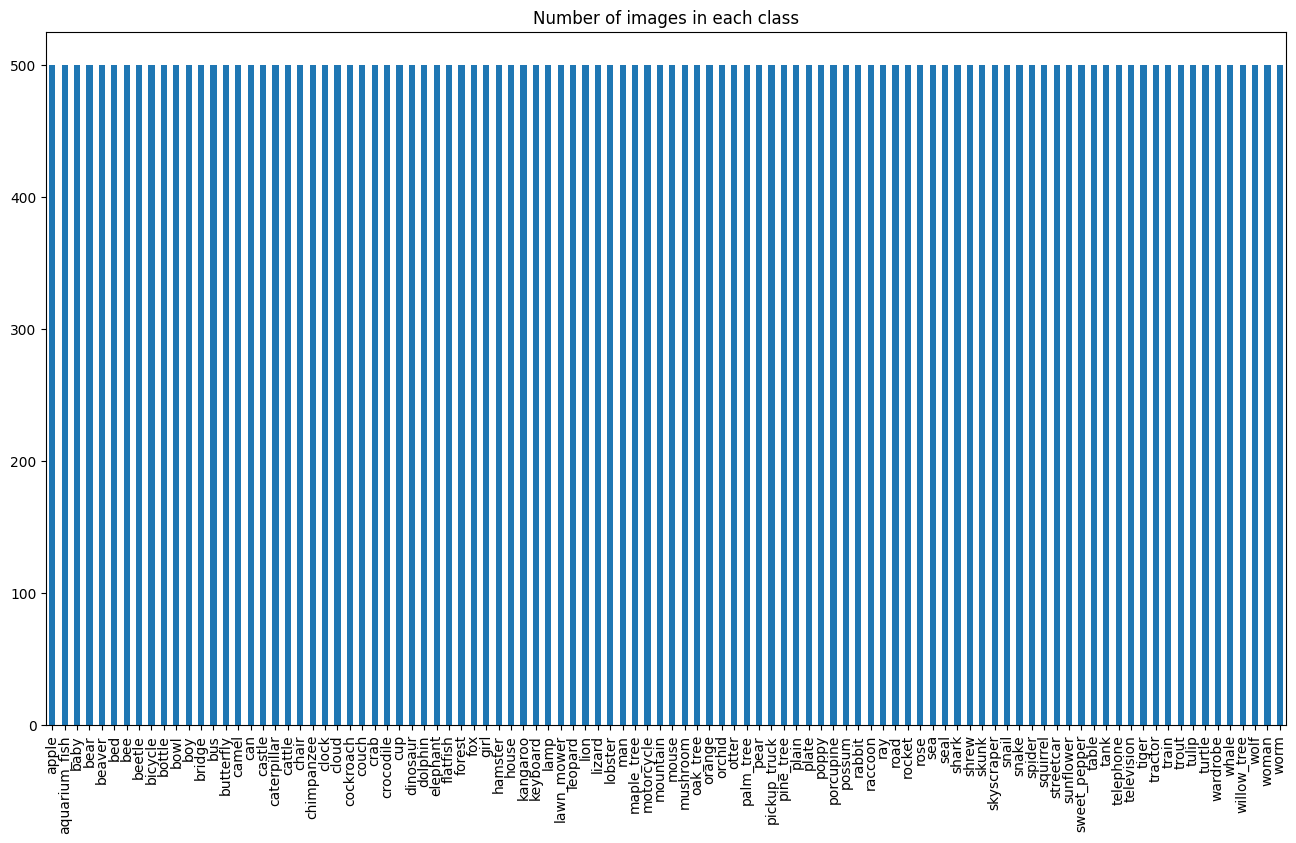

In [48]:
plt.figure(figsize=(16,9))
data = pd.DataFrame({'labels': labels, 'image_links':train_fns})
data.groupby(labels).image_links.count().plot.bar()
plt.title('Number of images in each class')
plt.show()

## **Data preparation**

### **Spliting train/validation/test set**

In [49]:
from sklearn.model_selection import train_test_split

train_fns, val_fns, y_label_train, y_label_val = train_test_split(train_fns, labels, test_size = 0.2, random_state = 1)

print('The number of training data: {}'.format(len(train_fns)))
print('The number of validation data:  {}'.format(len(val_fns)))


The number of training data: 40000
The number of validation data:  10000


### **Data Generator** 

In [56]:
class customDataset(Sequence):
    def __init__(self, 
                 all_filenames, 
                 labels,
                 batch_size, 
                 index2class,
                 input_dim,
                 n_channels,
                 n_classes=2,
                 augment = True,
                 shuffle=True):
        self.all_filenames = all_filenames
        self.labels = labels,
        self.batch_size = batch_size
        self.index2class = index2class
        self.input_dim = input_dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.augment = augment
        self.shuffle = True
        self.on_epoch_end()

    def __len__(self):
        # Trả về số lượng batch trên 1 epoch
        return int(np.floor(len(self.all_filenames)/self.batch_size))
    
    def __getitem__(self, index):

        #  Lấy ra indexes của batch thứ index
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # List all filenames trong một batch
        all_filnames_temp = [self.all_filenames[k] for k in batch_indexes]

        # Khởi tạo data
        X,y = self.__data_generation(all_filnames_temp)
        y = to_categorical(y, 100)
        return X,y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.all_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, all_filenames_temp):
        X = np.empty((self.batch_size, *self.input_dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Khởi tạo dữ liệu
        for i, fn in enumerate(all_filenames_temp):
            img = cv2.imread(fn)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.input_dim)
            label = fn.split('\\')[4]
            label = self.index2class[label]
    
            X[i,] = img/255
            y[i] = label
            if self.augment == True:
                X = self.__augment_batch(X)
        return X,y

    # Augmentation cho dữ liệu ảnh
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p=0.5),
                                   albu.VerticalFlip(p=0.5),
                                   albu.GridDistortion(p=0.2),
                                   albu.ElasticTransform(p=0.2)])
        return composition(image=img)['image']
    
    # Augmentation mỗi batch dữ liệu ảnh
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
        return img_batch

**Thư viện albumentations của python giúp real-time Data augmentation.**

In [57]:
dict_labels = {'butterfly': 0,'bee': 1,'cockroach': 2,'caterpillar': 3,'beetle': 4,'rocket': 5,'lawn_mower': 6,'tractor': 7,'tank': 8,'streetcar': 9,
            'forest': 10,'cloud': 11,'mountain': 12,'sea': 13,'plain': 14,'possum': 15,'fox': 16,'raccoon': 17,'porcupine': 18,'skunk': 19,
            'seal': 20,'dolphin': 21,'beaver': 22,'whale': 23,'otter': 24,'pine_tree': 25,'palm_tree': 26,'maple_tree': 27,'willow_tree': 28,'oak_tree': 29,
            'television': 30,'keyboard': 31,'lamp': 32,'telephone': 33,'clock': 34,'lobster': 35,'snail': 36,'worm': 37,'spider': 38,'crab': 39,
            'bear': 40,'leopard': 41,'tiger': 42,'wolf': 43,'lion': 44,'bottle': 45,'plate': 46,'bowl': 47,'can': 48,'cup': 49,
            'motorcycle': 50,'train': 51,'bicycle': 52,'pickup_truck': 53,'bus': 54,'pear': 55,'mushroom': 56,'sweet_pepper': 57,'apple': 58,'orange': 59,
            'camel': 60,'chimpanzee': 61,'cattle': 62,'kangaroo': 63,'elephant': 64,'table': 65,'wardrobe': 66,'chair': 67,'couch': 68,'bed': 69,
            'crocodile': 70,'lizard': 71,'turtle': 72,'snake': 73,'dinosaur': 74,'house': 75,'castle': 76,'skyscraper': 77,'road': 78,'bridge': 79,
            'baby': 80,'girl': 81,'woman': 82,'man': 83,'boy': 84,'shrew': 85,'squirrel': 86,'rabbit': 87,'hamster': 88,'mouse': 89,
            'sunflower': 90,'tulip': 91,'orchid': 92,'poppy': 93,'rose': 94,'shark': 95,'flatfish': 96,'ray': 97,'aquarium_fish': 98,'trout': 99}


train_data_generator = customDataset(
    all_filenames = train_fns,
    labels = y_label_train,
    batch_size = 8,
    index2class = dict_labels,
    input_dim = (224, 224),
    n_channels = 3,
    n_classes = 100,
    augment=True,
    shuffle = True
)

val_data_generator = customDataset(
    all_filenames = val_fns,
    labels = y_label_val,
    batch_size = 8,
    index2class = dict_labels,
    input_dim = (224, 224),
    n_channels = 3,
    n_classes = 100,
    augment=False,
    shuffle = True
)

In [59]:
X, y = train_data_generator.__getitem__(0)

print(X.shape)
print(y.shape)

(8, 224, 224, 3)
(8, 100)


### **Kiểm tra dữ liệu Augumentation**

In [62]:
check_aug=['data\\cifar100\\test\\flowers\\rose\\mountain_rose_s_000071.png']*32
check_generator = customDataset(
    all_filenames = check_aug,
    labels = y_label_val,
    batch_size = 20,
    index2class = dict_labels,
    input_dim = (224, 224),
    n_channels = 3,
    n_classes = 100,
    augment=True,
    shuffle = False
)

In [63]:
X_batch, y_batch = check_generator.__getitem__(0)

print(X_batch.shape)
print(y_batch.shape)

(20, 224, 224, 3)
(20, 100)


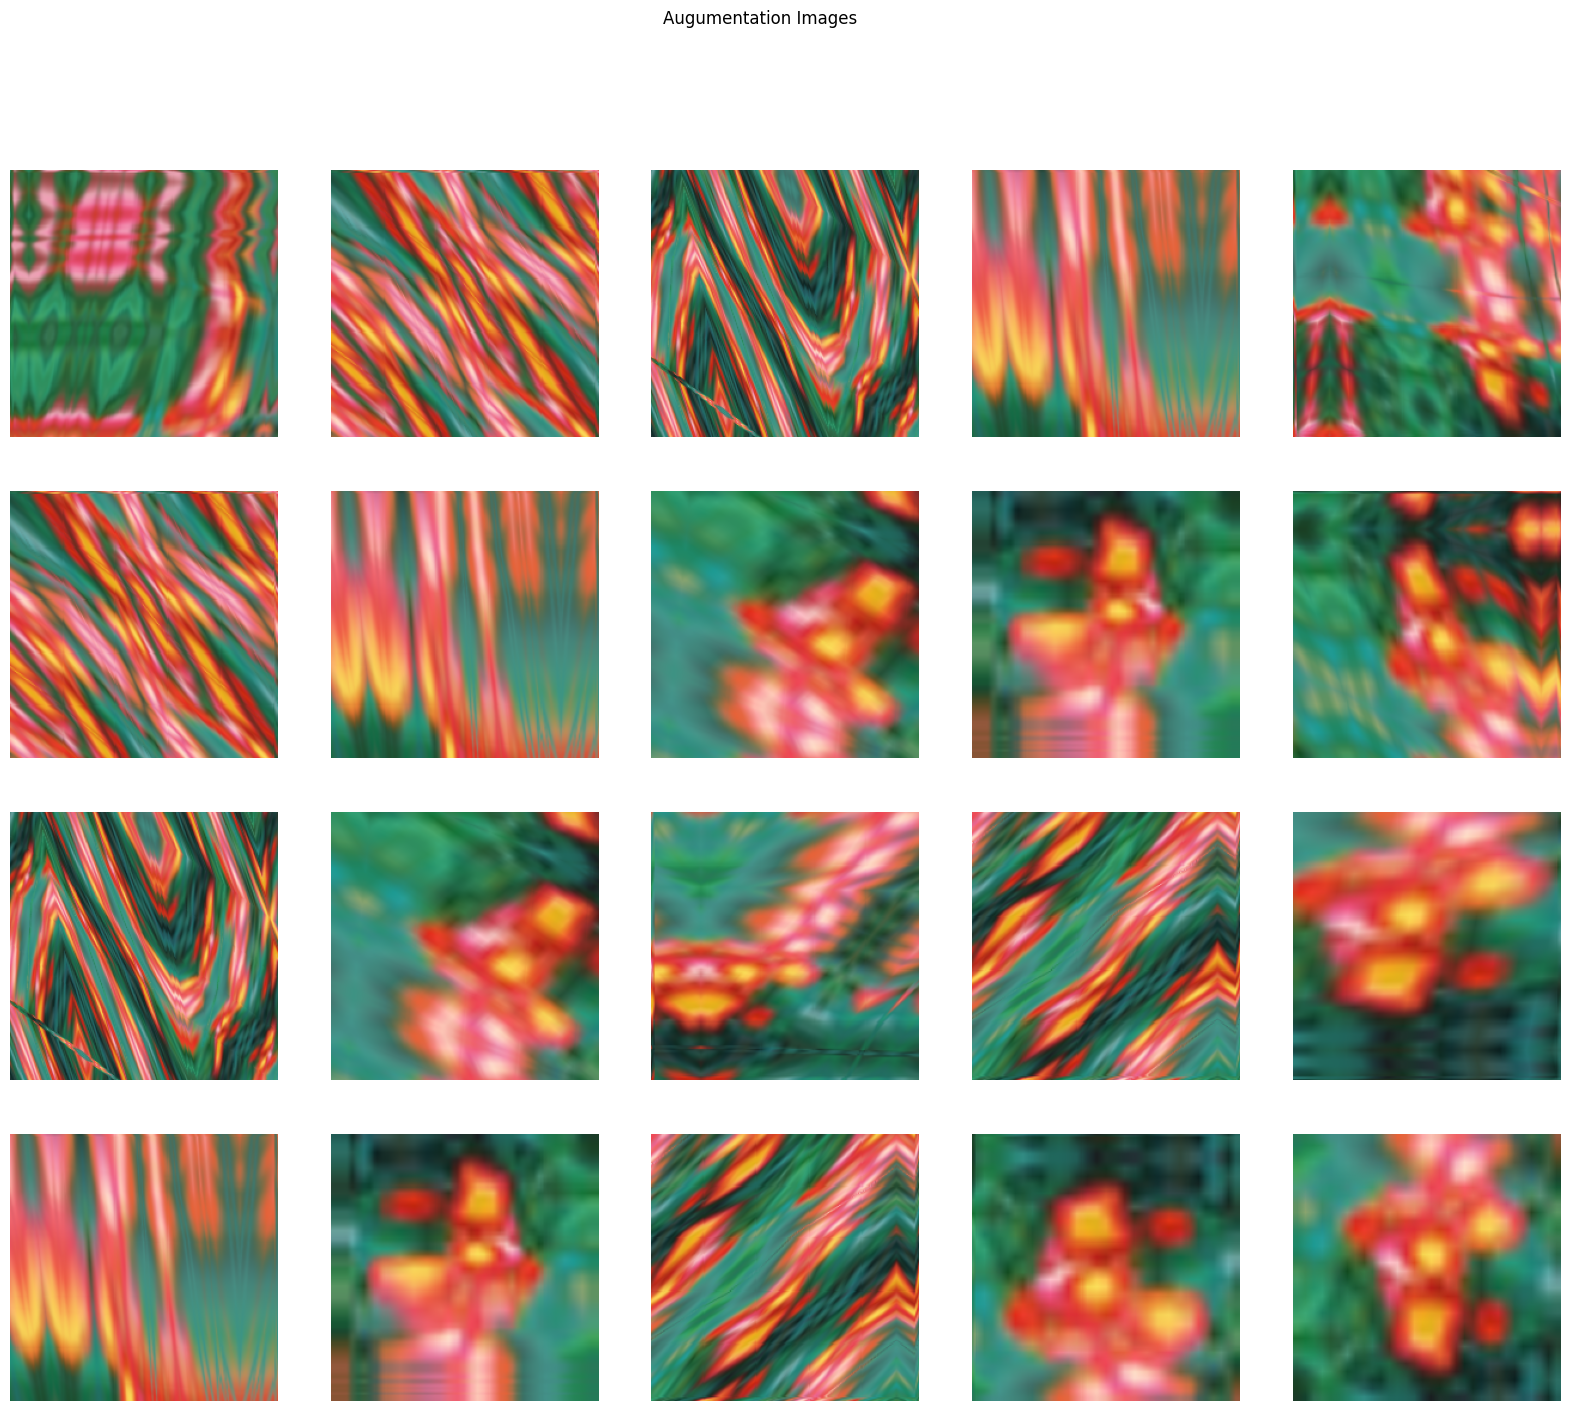

In [71]:
import matplotlib.pyplot as plt

# Khởi tạo subplot với 4 dòng 5 cột.
fg, ax = plt.subplots(4, 5, figsize=(20, 16))
fg.suptitle('Augumentation Images')

for i in np.arange(4):
  for j in np.arange(5):
    ax[i, j].imshow(X_batch[i + j + j*i])
    ax[i, j].set_xlabel('Image '+str(i+j+j*i))
    ax[i, j].axis('off')
plt.show()

## **Training Model**

### **Model Architecture**

Mình sử dụng phương pháp transfer learning, kiến trúc mạng EfficientNetB0 với Weight của mô hình đã được training trên bộ dữ liệu ImageNet.

In [72]:
#resizing the images as per EfficientNetB0 to size (224, 224)
height = 224
width = 224
channels = 3

n_classes = 100
input_shape = (height, width, channels)

epochs = 10
batch_size = 64

In [73]:
from keras.applications.efficientnet import EfficientNetB0
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

efnb0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape, classes=n_classes)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
Total params: 4,177,671
Trainable params: 4,135,648
Non-trainable params: 42,023
_________________________________________________________________


### **Warm up**

Warm up là quá trình cần thiết để mô hình hội tụ nhanh hơn. Warm up sẽ đóng băng lại các layers CNN để cho hệ số của chúng không đổi và chỉ train lại trên các Fully Conntected Layers ở cuối cùng. Mục đích của warm up là giữ nguyên được các đặc trưng bậc cao (high-level) đã được học từ pretrained-model mà những đặc trưng này là tốt vì được huấn luyện trên bộ dữ liệu có kích thước lớn hơn và có độ chính xác cao hơn sao với khởi tạo hệ số ngẫu nhiên.

In [10]:
for layer in model.layers[:1]:
  layer.trainable = False

for layer in model.layers:
  print('Layer: {} ; Trainable: {}'.format(layer, layer.trainable))


Layer: <keras.engine.functional.Functional object at 0x000001F824CF9FA0> ; Trainable: False
Layer: <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000001F821661370> ; Trainable: True
Layer: <keras.layers.regularization.dropout.Dropout object at 0x000001F824D0BFA0> ; Trainable: True
Layer: <keras.layers.core.dense.Dense object at 0x000001F8250A3C40> ; Trainable: True


### **Set up hyperparameter**

In [74]:
optimizer = Adam(lr=0.0001)

# early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

# reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)

# model compiling
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\Chi Khang\anaconda3\envs\chikhang\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [75]:
history = model.fit(train_data_generator,
                    validation_data=val_data_generator,
                    verbose=1,
                    validation_steps=5,
                    epochs=1)

4088/5000 [=======================>......] - ETA: 39:48 - loss: 3.4284 - accuracy: 0.1919

**Giảm Overfiting:**
- Sử dụng Layer Dropout giảm bớt các kết nối Fully Connected
- Phương pháp hiểu chuẩn (**regularization**) bằng cách thêm vào loss function thành phần norm chuẩn Frobenius của ma trận hệ số các layers.

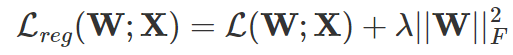

In [ ]:
# Khai báo trực tiếp vào tham số kernel_regularizer của keras layer

from keras import regularizers
model.add(Dense(64, input_dim=64,
    kernel_regularizer=regularizers.l2(0.01),
    activity_regularizer=regularizers.l2(0.01)))

## **Fine tuning model**

In [ ]:
for layer in model.layers[:1]:
  layer.trainable = True

for layer in model.layers:
  print('Layer: {} ; Trainable: {}'.format(layer, layer.trainable))

In [107]:
model_history = model.fit(train_data_generator,
                        validation_data=val_data_generator,
                        callbacks=[early_stop, rlrop],
                        verbose=1,
                        epochs=epochs)

#saving the trained model weights as data file in .h5 format
model.save_weights("cifar_efficientnetb0_weights.h5")

C:\Users\Chi Khang\AppData\Local\Temp\ipykernel_17340\3461622602.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_data_generator,


Epoch 1/10
  69/6250 [..............................] - ETA: 4:06:06 - loss: 4.7151 - accuracy: 0.0127

KeyboardInterrupt: 

## **References:**
1. https://www.kaggle.com/code/micajoumathematics/fine-tuning-efficientnetb0-on-cifar-100

2. https://github.com/chetnakhanna16/CIFAR100_ImageRecognition/blob/master/EffiicientNetB0_CIFAR100.ipynb

3. https://towardsdatascience.com/cifar-100-transfer-learning-using-efficientnet-ed3ed7b89af2